# ImageJ-Tiff-Meta

With `imagej-tiff-meta` it is possible to read and write ImageJ overlays, which can serve e.g. as an interchange format for segmentations.

In the following example, ROIs saved as overlay from the file `box.tif` are read using the code, and displayed with matplotlib.

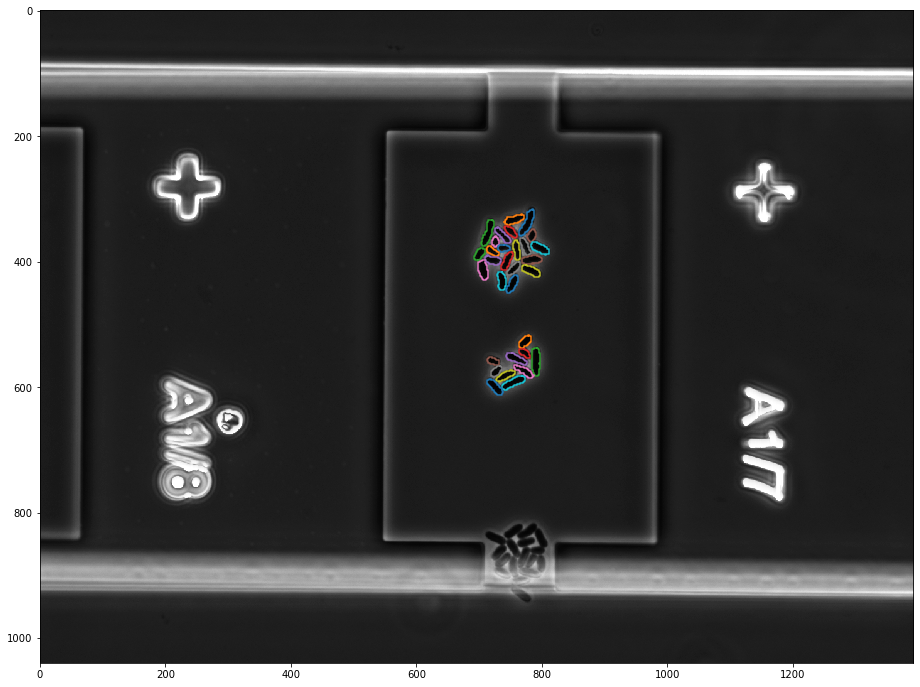

In [1]:
from imagej_tiff_meta import TiffFile
from matplotlib import pyplot

pyplot.rcParams['figure.figsize'] = 18, 12


with TiffFile('box.tif') as tiff:
    first_page = tiff.pages[0]
    data = first_page.asarray()
    pyplot.imshow(data, cmap='gray')
    for overlay in first_page.imagej_tags.parsed_overlays:
        pyplot.plot(overlay['coordinates'][:, 0] + overlay['left'],
                    overlay['coordinates'][:, 1] + overlay['top'])

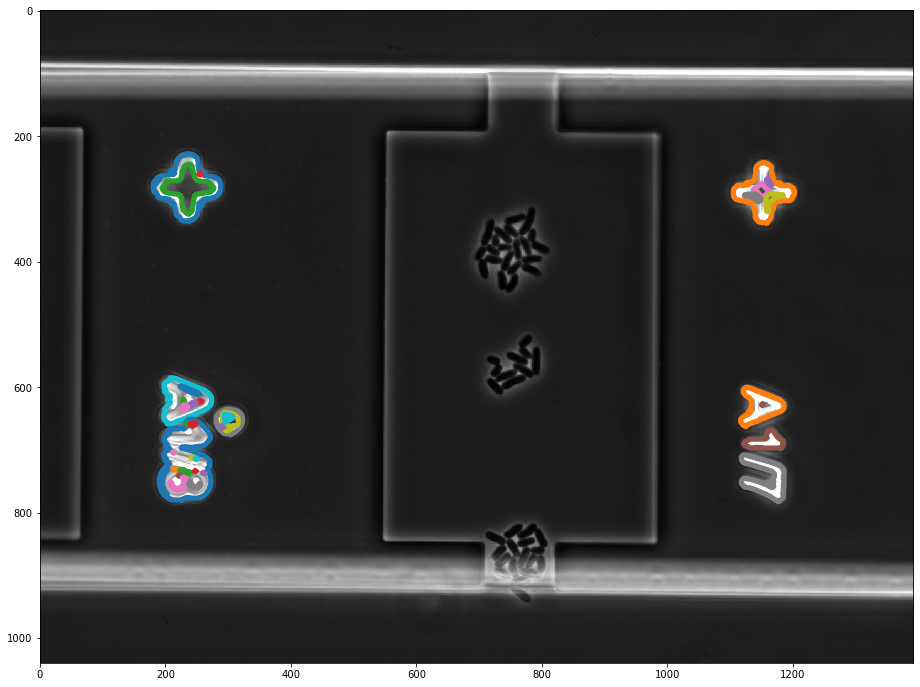

In [2]:
from imagej_tiff_meta import TiffFile, TiffWriter
from skimage.measure import label, regionprops, find_contours
import numpy as np
from matplotlib import pyplot

pyplot.rcParams['figure.figsize'] = 18, 12

# we just load the data

with TiffFile('box.tif') as tiff:
    first_page = tiff.pages[0]
    data = first_page.asarray()
    
# and create some ROI ourselves

segmentation = data > 0.5 * data.max()
labeled = label(segmentation)

for region in regionprops(labeled):
    if region.area > 10000:
        labeled[labeled == region.label] = 0
    elif region.area < 100:
        labeled[labeled == region.label] = 0

segmentation = 1.0 * (labeled > 0)

pyplot.imshow(data, cmap='gray')

contours = []

for contour in find_contours(segmentation, level=0.9999):
    contour = np.round(contour)
    contours.append(contour)
    pyplot.plot(contour[:, 1], contour[:, 0], lw=5)

# so we have image data and contours, lets write it to ImageJ compatible ROIs:

with TiffWriter('roi_test.tif') as tiff:
    for contour in contours:
        tiff.add_roi(contour[:, ::-1])
    
    tiff.save(data)

Yields the ROIs in ImageJ (screenshot):

![ImageJ window of the generated file](roi_test_imagejwindow.png)